[Decision Tree] Accuracy: 0.87


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1399/1399 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[Improved Neural Network] Accuracy: 0.83


<ipython-input-2-51a00434a9de>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette=colors)


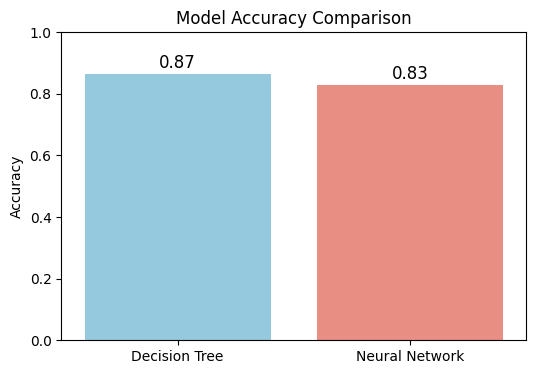

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#Load and preprocess data
accident_df = pd.read_csv("Accident_Information.csv")
vehicle_df = pd.read_csv("Vehicle_Information.csv")
data = pd.merge(accident_df, vehicle_df, on="Accident_Index", how="inner")
data.drop(columns=["Accident_Index"], inplace=True)

#Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

#Encode categorical columns
label_encoders = {}
for col in data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

#Features and labels
target_column = "Accident_Severity"
X = data.drop(columns=[target_column])
y = data[target_column]

#SMOTE balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Split data for both models
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"[Decision Tree] Accuracy: {accuracy_dt:.2f}")

#Neural Network Model
#One-hot encode labels
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

#Robust scaling (better for outliers)
rscaler = RobustScaler()
X_train_scaled = rscaler.fit_transform(X_train)
X_test_scaled = rscaler.transform(X_test)

#Define neural network
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train_scaled.shape[1]))
nn_model.add(BatchNormalization())
nn_model.add(ReLU())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(64))
nn_model.add(BatchNormalization())
nn_model.add(ReLU())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(32))
nn_model.add(ReLU())

nn_model.add(Dense(3, activation="softmax"))

#Compile model
opt = Adam(learning_rate=0.0005)
nn_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#Train model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = nn_model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

#Evaluate model
y_pred_nn = np.argmax(nn_model.predict(X_test_scaled), axis=1)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"[Improved Neural Network] Accuracy: {accuracy_nn:.2f}")

#Accuracy Comparison Plot
plt.figure(figsize=(6, 4))
models = ['Decision Tree', 'Neural Network']
accuracies = [accuracy_dt, accuracy_nn]
colors = ['skyblue', 'salmon']

sns.barplot(x=models, y=accuracies, palette=colors)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.show()